In [3490]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from imblearn.over_sampling import SMOTE
import warnings
import time
import itertools
warnings.filterwarnings("ignore")

test = pd.read_csv("PCOS.csv")

In [3491]:
def confusion_matrix_train(model, cutoff=0.5):
# Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    false_neg = cm[1,0]/(cm[1,0]+cm[1,1])
    false_pos = cm[0,1]/(cm[0,1]+cm[0,0])
    print("Classification accuracy = {:.4%}".format(accuracy))
    print("False Negative = {:.4%}".format(false_neg))
    print("False Positive = {:.4%}".format(false_pos))
    
def confusion_matrix_test(data,actual_values,model,cutoff=0.3):
    #Predict the values using the Logit model
    pred_values = model.predict(data)
    # Specify the bins
    bins=np.array([0,cutoff,1])
    #Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    # Return the confusion matrix and the accuracy
    false_neg = cm[1,0]/(cm[1,0]+cm[1,1])
    false_pos = cm[0,1]/(cm[0,1]+cm[0,0])
    print("Classification accuracy = {:.4%}".format(accuracy))
    print("False Negative = {:.4%}".format(false_neg))
    print("False Positive = {:.4%}".format(false_pos))

# Data Cleaning

In [3492]:
test = test.rename(columns={"Sl. No":"num", "Patient File No.": "patient", "PCOS (Y/N)":"PCOS", "Age (yrs)": "age", 
       'Weight (Kg)' : "weight", 'Height(Cm)':"height", "Blood Group": "blood_group",'Pulse rate(bpm)': "pulse_rate",
       'RR (breaths/min)': "RR", 'Hb(g/dl)': "hb", 'Cycle(R/I)': "cycle_ri", 'Cycle length(days)': "cycle",
       'Marraige Status (Yrs)': "marriage_years", 'Pregnant(Y/N)': "pregnant", 'No. of aborptions': "number_abortions",
       '  I   beta-HCG(mIU/mL)': "I", 'II    beta-HCG(mIU/mL)': "II", 'FSH(mIU/mL)': "FAH",
       'LH(mIU/mL)': "LH", 'FSH/LH': "FSH_LH", 'Hip(inch)': "hip", 'Waist(inch)': "waist", 'Waist:Hip Ratio': "hw_ratio",
       'TSH (mIU/L)': "TSH", 'AMH(ng/mL)': "AMH", 'PRL(ng/mL)':"PRL", 'Vit D3 (ng/mL)': "vit",
       'PRG(ng/mL)':"prg", 'RBS(mg/dl)':"rbs", 'Weight gain(Y/N)':"weight_gain", 'hair growth(Y/N)':"hair_growth",
       'Skin darkening (Y/N)': "skin_dark", 'Hair loss(Y/N)': "hair_loss", 'Pimples(Y/N)': "pimples",
       'Fast food (Y/N)': "fast_food", 'Reg.Exercise(Y/N)':"regular_exercise", 'BP _Systolic (mmHg)':"bp_systolic",
       'BP _Diastolic (mmHg)': "bp_distolic", 'Follicle No. (L)':"follicle_L", 'Follicle No. (R)': "follicle_R",
       'Avg. F size (L) (mm)':"ave_size_L", 'Avg. F size (R) (mm)':"ave_size_R", 'Endometrium (mm)':"endometrium", 'Unnamed: 44':"NA"})


In [3493]:
test = test.drop(columns = {'NA'})
test["hw_ratio"] = test["hip"]/test["waist"]
test["height"] = test["height"]/100
test["BMI"] = test["weight"]/np.square(test["height"])
test = test.drop('num', axis=1)
test = test.drop('patient', axis=1)
test = test.drop('II', axis=1)
test = test.drop('AMH', axis=1)
test = test.drop('FSH_LH', axis=1)
test.isnull().sum()

PCOS                0
age                 0
weight              0
height              0
BMI                 0
blood_group         0
pulse_rate          0
RR                  0
hb                  0
cycle_ri            0
cycle               0
marriage_years      1
pregnant            0
number_abortions    0
I                   0
FAH                 0
LH                  0
hip                 0
waist               0
hw_ratio            0
TSH                 0
PRL                 0
vit                 0
prg                 0
rbs                 0
weight_gain         0
hair_growth         0
skin_dark           0
hair_loss           0
pimples             0
fast_food           1
regular_exercise    0
bp_systolic         0
bp_distolic         0
follicle_L          0
follicle_R          0
ave_size_L          0
ave_size_R          0
endometrium         0
dtype: int64

In [3494]:
test = test[~((test['marriage_years'].isnull()) | (test['fast_food'].isnull()))]
test["PCOS"].value_counts()

0    363
1    176
Name: PCOS, dtype: int64

In [3495]:
test.columns

Index(['PCOS', 'age', 'weight', 'height', 'BMI', 'blood_group', 'pulse_rate',
       'RR', 'hb', 'cycle_ri', 'cycle', 'marriage_years', 'pregnant',
       'number_abortions', 'I', 'FAH', 'LH', 'hip', 'waist', 'hw_ratio', 'TSH',
       'PRL', 'vit', 'prg', 'rbs', 'weight_gain', 'hair_growth', 'skin_dark',
       'hair_loss', 'pimples', 'fast_food', 'regular_exercise', 'bp_systolic',
       'bp_distolic', 'follicle_L', 'follicle_R', 'ave_size_L', 'ave_size_R',
       'endometrium'],
      dtype='object')

# SMOTE

In [3496]:
train = test
train.shape

(539, 39)

In [3497]:
train["PCOS"].value_counts()

0    363
1    176
Name: PCOS, dtype: int64

In [3498]:
X=train.iloc[:,1:]
y=train.iloc[:,0]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1, random_state = 0)

In [3499]:
sm = SMOTE(random_state = 0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 175
Before OverSampling, counts of label '0': 363 

After OverSampling, the shape of train_X: (726, 38)
After OverSampling, the shape of train_y: (726,) 

After OverSampling, counts of label '1': 363
After OverSampling, counts of label '0': 363


In [3500]:
y = pd.DataFrame(y_train_res, columns=["PCOS"])
train = pd.concat([X_train_res, y], axis = 1) 
train = train.reindex(columns=["PCOS", 'age', 'weight', 'height', 'BMI', 'blood_group', 'pulse_rate', 'RR',
       'hb', 'cycle_ri', 'cycle', 'marriage_years', 'pregnant',
       'number_abortions', 'I', 'FAH', 'LH', 'hip', 'waist', 'hw_ratio', 'TSH',
       'PRL', 'vit', 'prg', 'rbs', 'weight_gain', 'hair_growth', 'skin_dark',
       'hair_loss', 'pimples', 'fast_food', 'regular_exercise', 'bp_systolic',
       'bp_distolic', 'follicle_L', 'follicle_R', 'ave_size_L', 'ave_size_R',
       'endometrium'])

### Changing blood_group to categorical

In [3501]:
blood_group_map = {11: "A_pos", 12: "A_neg", 13: "B_pos", 14: "B_neg", 15: "O_pos", 16: "O_neg", 17: "AB_pos", 18: "AB_neg"}

test.loc[:, "blood_group_cat"] = test.loc[:, "blood_group"].map(blood_group_map)

In [3502]:
test = test.drop('blood_group', axis=1)
test.head()

,PCOS,age,weight,height,BMI,pulse_rate,RR,hb,cycle_ri,cycle,...,fast_food,regular_exercise,bp_systolic,bp_distolic,follicle_L,follicle_R,ave_size_L,ave_size_R,endometrium,blood_group_cat
0,0,28,44.6,1.520,19.304017,78,22,10.48,2,5,...,1.0,0,110,80,3,3,18.0,18.0,8.5,O_pos
1,0,36,65.0,1.615,24.921163,74,20,11.70,2,5,...,0.0,0,120,70,3,5,15.0,14.0,3.7,O_pos
2,1,33,68.8,1.650,25.270891,72,18,11.80,2,5,...,1.0,0,120,80,13,15,18.0,20.0,10.0,A_pos
3,0,37,65.0,1.480,29.674945,72,20,12.00,2,5,...,0.0,0,120,70,2,2,15.0,14.0,7.5,B_pos
4,0,25,52.0,1.610,20.060954,72,18,10.00,2,5,...,0.0,0,120,80,3,4,16.0,14.0,7.0,A_pos


In [3503]:
blood_group_map = {11: "A_pos", 12: "A_neg", 13: "B_pos", 14: "B_neg", 15: "O_pos", 16: "O_neg", 17: "AB_pos", 18: "AB_neg"}

train.loc[:, "blood_group_cat"] = train.loc[:, "blood_group"].map(blood_group_map)

In [3504]:
train = train.drop('blood_group', axis=1)
train.tail()

,PCOS,age,weight,height,BMI,pulse_rate,RR,hb,cycle_ri,cycle,...,fast_food,regular_exercise,bp_systolic,bp_distolic,follicle_L,follicle_R,ave_size_L,ave_size_R,endometrium,blood_group_cat
721,1,30,53.841534,1.549321,22.342671,73,19,10.602264,2,5,...,0.488681,1,120,74,12,14,17.466043,18.000000,8.455659,B_neg
722,1,26,75.981147,1.587757,30.132388,76,19,10.865410,2,6,...,1.000000,1,117,77,7,9,16.560793,17.551366,8.387841,B_pos
723,1,25,66.780093,1.788259,20.834550,73,19,10.195689,2,4,...,0.000000,0,110,70,12,9,18.195689,17.646767,8.882587,A_pos
724,1,29,62.586575,1.522756,26.996712,72,18,11.458657,2,5,...,1.000000,0,118,80,4,7,11.240276,15.275617,8.731451,B_neg
725,1,32,63.000000,1.638646,23.464079,72,18,10.975628,4,8,...,1.000000,0,110,80,5,6,18.027081,20.891678,8.978336,O_neg


In [3505]:
train = pd.get_dummies(train, columns = ['blood_group_cat'])
test = pd.get_dummies(test, columns = ['blood_group_cat'])

# Baseline Model

In [3506]:
import statsmodels.formula.api as sm

In [3507]:
train.columns

Index(['PCOS', 'age', 'weight', 'height', 'BMI', 'pulse_rate', 'RR', 'hb',
       'cycle_ri', 'cycle', 'marriage_years', 'pregnant', 'number_abortions',
       'I', 'FAH', 'LH', 'hip', 'waist', 'hw_ratio', 'TSH', 'PRL', 'vit',
       'prg', 'rbs', 'weight_gain', 'hair_growth', 'skin_dark', 'hair_loss',
       'pimples', 'fast_food', 'regular_exercise', 'bp_systolic',
       'bp_distolic', 'follicle_L', 'follicle_R', 'ave_size_L', 'ave_size_R',
       'endometrium', 'blood_group_cat_AB_neg', 'blood_group_cat_AB_pos',
       'blood_group_cat_A_neg', 'blood_group_cat_A_pos',
       'blood_group_cat_B_neg', 'blood_group_cat_B_pos',
       'blood_group_cat_O_neg', 'blood_group_cat_O_pos'],
      dtype='object')

In [3508]:
baseline = sm.logit("PCOS ~ age + weight + height + pulse_rate + RR + hb + cycle_ri + cycle + marriage_years + pregnant + number_abortions + I + FAH + LH + hip + waist + TSH + PRL + vit + prg + rbs + weight_gain + hair_growth + skin_dark + hair_loss + pimples + fast_food + regular_exercise + bp_systolic + bp_distolic + follicle_L + follicle_R + ave_size_L + ave_size_R + endometrium + blood_group_cat_AB_neg + blood_group_cat_AB_pos + blood_group_cat_A_neg + blood_group_cat_A_pos + blood_group_cat_B_neg + blood_group_cat_B_pos + blood_group_cat_O_neg", data = train).fit()
baseline.summary()

Optimization terminated successfully.
         Current function value: 0.211926
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  726
Model:                          Logit   Df Residuals:                      683
Method:                           MLE   Df Model:                           42
Date:                Wed, 08 Mar 2023   Pseudo R-squ.:                  0.6943
Time:                        23:04:26   Log-Likelihood:                -153.86
converged:                       True   LL-Null:                       -503.22
Covariance Type:            nonrobust   LLR p-value:                5.985e-120
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -10.7016      9.259     -1.156      0.248     -28.849       7.446
age                       -0.0632      0.043     -1.456      0.146      -0.148       0.022
weight                     0.0290      0.025      1.164      0.245      -0.020       0.078
height                    -2.7473      3.269     -0.840      0.401      -9.155       3.661
pulse_rate                 0.1875      0.078      2.396      0.017       0.034       0.341
RR                        -0.2901      0.131     -2.208      0.027      -0.548      -0.033
hb                        -0.0210      0.212     -0.099      0.921      -0.438       0.395
cycle_ri                   0.5349      0.207      2.585      0.010       0.129       0.940
cycle                     -0.1985      0.104     -1.900      0.057      -0.403       0.006
marriage_years            -0.0365      0.050     -0.734      0.463      -0.134       0.061
pregnant                  -0.6529      0.337     -1.936      0.053      -1.314       0.008
number_abortions          -0.6542      0.314     -2.081      0.037      -1.270      -0.038
I                      -4.676e-05   3.94e-05     -1.186      0.236      -0.000    3.05e-05
FAH                       -0.0585      0.052     -1.121      0.262      -0.161       0.044
LH                         0.0959      0.066      1.451      0.147      -0.034       0.225
hip                        0.1238      0.093      1.331      0.183      -0.058       0.306
waist                     -0.1231      0.103     -1.198      0.231      -0.324       0.078
TSH                        0.0781      0.037      2.106      0.035       0.005       0.151
PRL                        0.0052      0.013      0.401      0.688      -0.020       0.030
vit                        0.0006      0.001      0.397      0.691      -0.002       0.003
prg                       -0.5435      0.555     -0.979      0.328      -1.631       0.545
rbs                        0.0177      0.011      1.603      0.109      -0.004       0.039
weight_gain                1.3827      0.395      3.501      0.000       0.609       2.157
hair_growth                1.8865      0.391      4.829      0.000       1.121       2.652
skin_dark                  0.9237      0.365      2.532      0.011       0.209       1.639
hair_loss                  0.0007      0.351      0.002      0.998      -0.687       0.689
pimples                    0.8147      0.347      2.349      0.019       0.135       1.495
fast_food                  1.2779      0.356      3.586      0.000       0.580       1.976
regular_exercise           0.1518      0.404      0.375      0.707      -0.641       0.944
bp_systolic               -0.0246      0.027     -0.920      0.358      -0.077       0.028
bp_distolic               -0.0267      0.036     -0.751      0.453      -0.097       0.043
follicle_L                 0.1889      0.065      2.905      0.004       0.061       0.316
follicle_R                 0.4460      0.065      6.902 

Classification accuracy = 89.4249%
False Negative = 7.9545%
False Positive = 11.8457%


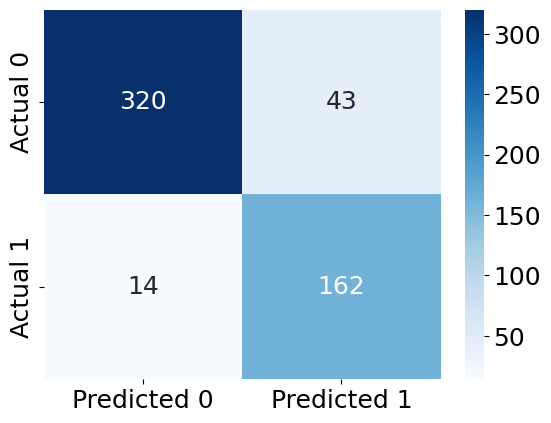

In [3509]:
confusion_matrix_test(test, test.PCOS, baseline, cutoff = 0.4)

# EDA

In [3510]:
# sns.scatterplot(x = 'age', y = 'PCOS', data = train, color = 'orange') #Visualizing data
logit_model = sm.logit('PCOS ~ age', data = train).fit() #Developing logistic regression model
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.659884
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  726
Model:                          Logit   Df Residuals:                      724
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Mar 2023   Pseudo R-squ.:                 0.04799
Time:                        23:04:26   Log-Likelihood:                -479.08
converged:                       True   LL-Null:                       -503.22
Covariance Type:            nonrobust   LLR p-value:                 3.661e-12
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1769      0.484      6.562      0.000       2.228       4.126
age           -0.1035      0.016     -6.625      0.000      -0.134      -0.073
==============================================================================
"""

In [3511]:
logit_model = sm.logit('PCOS ~ BMI', data = train).fit() #Developing logistic regression model
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.669187
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  726
Model:                          Logit   Df Residuals:                      724
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Mar 2023   Pseudo R-squ.:                 0.03457
Time:                        23:04:26   Log-Likelihood:                -485.83
converged:                       True   LL-Null:                       -503.22
Covariance Type:            nonrobust   LLR p-value:                 3.672e-09
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8740      0.514     -5.594      0.000      -3.881      -1.867
BMI            0.1169      0.021      5.652      0.000       0.076       0.157
==============================================================================
"""

In [3512]:
logit_model = sm.logit('PCOS ~ pulse_rate', data = train).fit() #Developing logistic regression model
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.690836
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  726
Model:                          Logit   Df Residuals:                      724
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Mar 2023   Pseudo R-squ.:                0.003334
Time:                        23:04:27   Log-Likelihood:                -501.55
converged:                       True   LL-Null:                       -503.22
Covariance Type:            nonrobust   LLR p-value:                   0.06699
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9235      1.794     -1.630      0.103      -6.439       0.592
pulse_rate     0.0399      0.024      1.632      0.103      -0.008       0.088
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 0.690836
         Iterations 5


<AxesSubplot:xlabel='pulse_rate', ylabel='PCOS'>

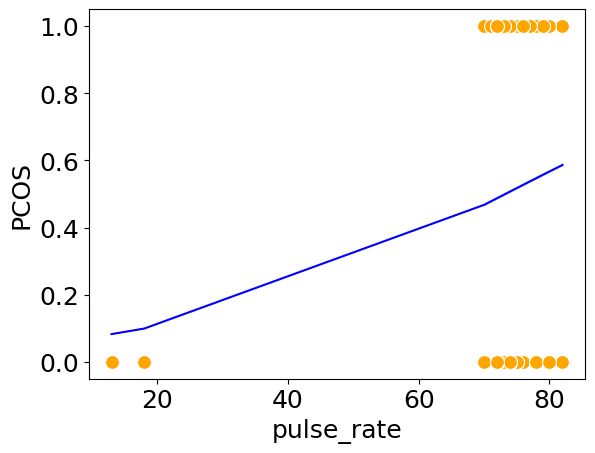

In [3513]:
sns.scatterplot(x = 'pulse_rate', y = 'PCOS', data = train, color = 'orange') #Visualizing data
logit_model = sm.logit(formula = 'PCOS~pulse_rate', data = train).fit() #Developing logistic regression model
sns.lineplot(x = 'pulse_rate', y= logit_model.predict(train), data = train, color = 'blue') #Visualizing model

In [3514]:
logit_model = sm.logit('PCOS ~ cycle_ri', data = train).fit() #Developing logistic regression model
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.636437
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  726
Model:                          Logit   Df Residuals:                      724
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Mar 2023   Pseudo R-squ.:                 0.08182
Time:                        23:04:29   Log-Likelihood:                -462.05
converged:                       True   LL-Null:                       -503.22
Covariance Type:            nonrobust   LLR p-value:                 1.144e-19
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0734      0.250     -8.298      0.000      -2.563      -1.584
cycle_ri       0.8092      0.095      8.528      0.000       0.623       0.995
==============================================================================
"""

In [3515]:
logit_model = sm.logit('PCOS ~ marriage_years', data = train).fit() #Developing logistic regression model
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.680692
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  726
Model:                          Logit   Df Residuals:                      724
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Mar 2023   Pseudo R-squ.:                 0.01797
Time:                        23:04:29   Log-Likelihood:                -494.18
converged:                       True   LL-Null:                       -503.22
Covariance Type:            nonrobust   LLR p-value:                 2.113e-05
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.5312      0.148      3.595      0.000       0.242       0.821
marriage_years    -0.0725      0.018     -4.131      0.000      -0.107      -0.038
==================================================================================
"""

In [3516]:
logit_model = sm.logit('PCOS ~ number_abortions', data = train).fit() #Developing logistic regression model
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.682606
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  726
Model:                          Logit   Df Residuals:                      724
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Mar 2023   Pseudo R-squ.:                 0.01521
Time:                        23:04:30   Log-Likelihood:                -495.57
converged:                       True   LL-Null:                       -503.22
Covariance Type:            nonrobust   LLR p-value:                 9.144e-05
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1110      0.080      1.391      0.164      -0.045       0.267
number_abortions    -0.5145      0.142     -3.622      0.000      -0.793      -0.236
====================================================================================
"""

In [3517]:
logit_model = sm.logit('PCOS ~ hw_ratio', data = train).fit() #Developing logistic regression model
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.692500
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  726
Model:                          Logit   Df Residuals:                      724
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Mar 2023   Pseudo R-squ.:               0.0009334
Time:                        23:04:30   Log-Likelihood:                -502.76
converged:                       True   LL-Null:                       -503.22
Covariance Type:            nonrobust   LLR p-value:                    0.3324
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3968      1.444     -0.967      0.333      -4.228       1.434
hw_ratio       1.2397      1.280      0.968      0.333      -1.269       3.749
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 0.692500
         Iterations 3


<AxesSubplot:xlabel='hw_ratio', ylabel='PCOS'>

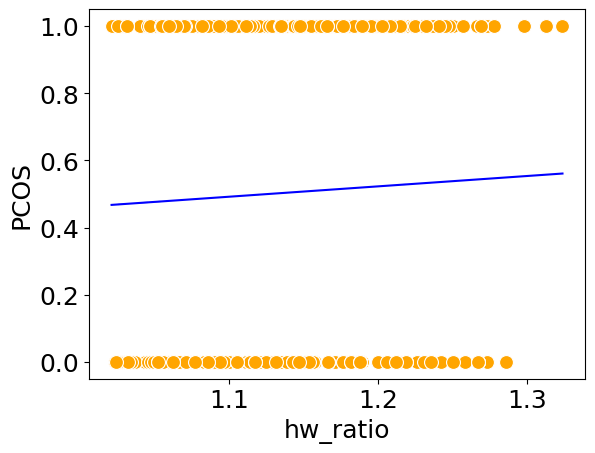

In [3518]:
sns.scatterplot(x = 'hw_ratio', y = 'PCOS', data = train, color = 'orange') #Visualizing data
logit_model = sm.logit(formula = 'PCOS~hw_ratio', data = train).fit() #Developing logistic regression model
sns.lineplot(x = 'hw_ratio', y= logit_model.predict(train), data = train, color = 'blue') #Visualizing model

Classification accuracy = 52.1336%
False Negative = 61.3636%
False Positive = 41.3223%


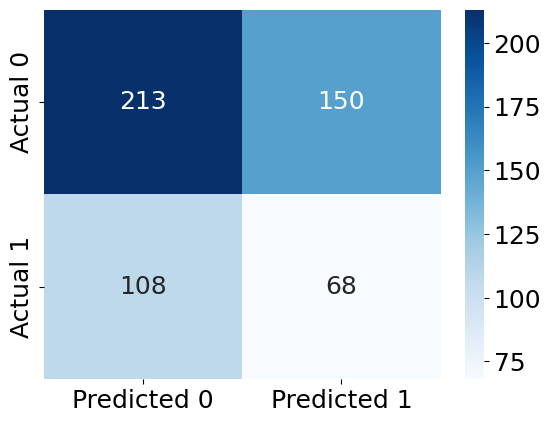

In [3526]:
confusion_matrix_test(test, test.PCOS, logit_model, cutoff = 0.5)

In [3527]:
#Binning marriage_years
binned_hw = pd.qcut(train['hw_ratio'], 5, retbins=True)
train['hw_binned'] = binned_hw[0]


In [3528]:
#Finding percentage of people having diabetes in each Age bin
hw_data = train.groupby('hw_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
hw_data

,hw_binned,PCOS_percent,nobs
0,"(1.02, 1.071]",0.409091,154
1,"(1.071, 1.105]",0.564286,140
2,"(1.105, 1.135]",0.471831,142
3,"(1.135, 1.182]",0.572414,145
4,"(1.182, 1.324]",0.489655,145


Text(0.5, 0, 'hw_ratio Bins')

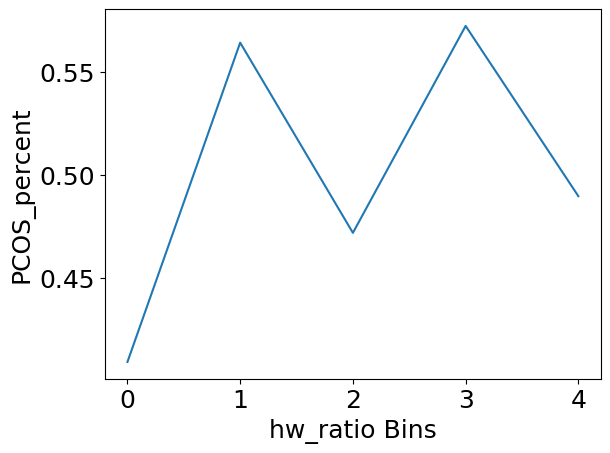

In [3529]:
sns.lineplot(x = hw_data.index, y = hw_data['PCOS_percent'])
plt.xlabel('hw_ratio Bins')

In [3530]:
#Creating a function to bin marriage_years so that it can be applied to both the test and train datasets
def var_transform(data):
    binned_hw = pd.qcut(train['hw_ratio'],5,retbins=True)
    bins = binned_hw[1]
    data['hw_binned'] = pd.cut(data['hw_ratio'],bins = bins)
    dum = pd.get_dummies(data.hw_binned,drop_first = True)
    dum.columns = ['hw_ratio'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

In [3531]:
#Binning age using the function var_transform()
train = var_transform(train)
test = var_transform(test)

Optimization terminated successfully.
         Current function value: 0.685568
         Iterations 4


<AxesSubplot:xlabel='hw_ratio', ylabel='PCOS'>

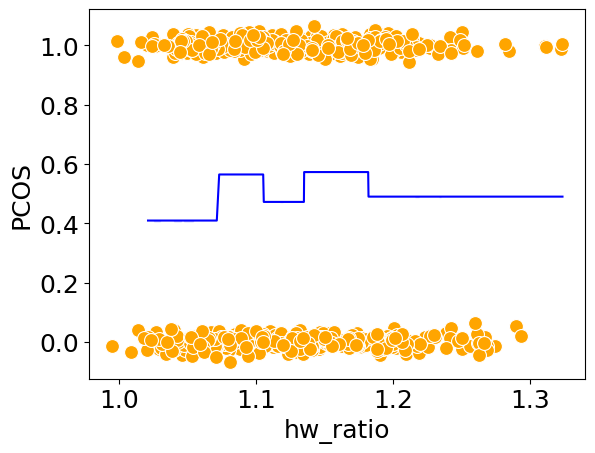

In [3532]:
#Model with binned marriage_years
sns.scatterplot(x = jitter(train.hw_ratio,0), y = jitter(train.PCOS,0), data = train, color = 'orange')
logit_model = sm.logit(formula = 'PCOS~' + '+'.join(['hw_ratio'+str(x) for x in range(1,5)]), data = train).fit()
sns.lineplot(x = 'hw_ratio', y= logit_model.predict(train), data = train, color = 'blue')

In [3533]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  726
Model:                          Logit   Df Residuals:                      721
Method:                           MLE   Df Model:                            4
Date:                Wed, 08 Mar 2023   Pseudo R-squ.:                 0.01093
Time:                        23:05:00   Log-Likelihood:                -497.72
converged:                       True   LL-Null:                       -503.22
Covariance Type:            nonrobust   LLR p-value:                   0.02651
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3677      0.164     -2.244      0.025      -0.689      -0.046
hw_ratio1      0.6263      0.236      2.649      0.008       0.163       1.090
hw_ratio2      0.2549      0.235      1.086      0.278      -0.205       0.715
hw_ratio3      0.6594      0.235      2.811      0.005       0.200       1.119
hw_ratio4      0.3263      0.233      1.398      0.162      -0.131       0.784
==============================================================================
"""

Some of the bins of hw_ratio are now significant!

Classification accuracy = 57.8850%
False Negative = 59.0909%
False Positive = 33.8843%


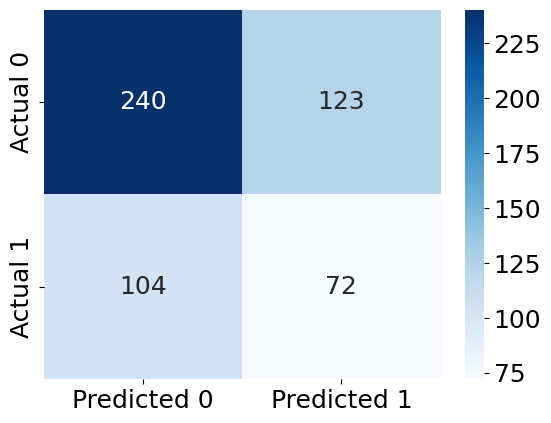

In [3535]:
confusion_matrix_test(test, test.PCOS, logit_model, cutoff = 0.5)

Accuracy increased, FNR decreased, FPR decreased. Include hw_ratio transformation!

In [3214]:
logit_model = sm.logit('PCOS ~ follicle_R', data = train).fit() #Developing logistic regression model
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.410365
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  726
Model:                          Logit   Df Residuals:                      724
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Mar 2023   Pseudo R-squ.:                  0.4080
Time:                        21:54:38   Log-Likelihood:                -297.92
converged:                       True   LL-Null:                       -503.22
Covariance Type:            nonrobust   LLR p-value:                 2.714e-91
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.8184      0.286    -13.328      0.000      -4.380      -3.257
follicle_R     0.5167      0.037     14.115      0.000       0.445       0.588
==============================================================================
"""

## Forward Selection

In [3536]:
train.head(2)

,PCOS,age,weight,height,BMI,pulse_rate,RR,hb,cycle_ri,cycle,...,blood_group_cat_A_pos,blood_group_cat_B_neg,blood_group_cat_B_pos,blood_group_cat_O_neg,blood_group_cat_O_pos,hw_binned,hw_ratio1,hw_ratio2,hw_ratio3,hw_ratio4
0,1,31,50.0,1.52,21.641274,80,20,11.0,2,5,...,0,0,1,0,0,"(1.021, 1.071]",0,0,0,0
1,0,28,70.0,1.58,28.040378,72,18,12.0,2,5,...,0,0,0,0,1,"(1.105, 1.135]",0,1,0,0


In [3537]:
train.columns

Index(['PCOS', 'age', 'weight', 'height', 'BMI', 'pulse_rate', 'RR', 'hb',
       'cycle_ri', 'cycle', 'marriage_years', 'pregnant', 'number_abortions',
       'I', 'FAH', 'LH', 'hip', 'waist', 'hw_ratio', 'TSH', 'PRL', 'vit',
       'prg', 'rbs', 'weight_gain', 'hair_growth', 'skin_dark', 'hair_loss',
       'pimples', 'fast_food', 'regular_exercise', 'bp_systolic',
       'bp_distolic', 'follicle_L', 'follicle_R', 'ave_size_L', 'ave_size_R',
       'endometrium', 'blood_group_cat_AB_neg', 'blood_group_cat_AB_pos',
       'blood_group_cat_A_neg', 'blood_group_cat_A_pos',
       'blood_group_cat_B_neg', 'blood_group_cat_B_pos',
       'blood_group_cat_O_neg', 'blood_group_cat_O_pos', 'hw_binned',
       'hw_ratio1', 'hw_ratio2', 'hw_ratio3', 'hw_ratio4'],
      dtype='object')

In [3538]:
X = train[['age', 'weight', 'height', 'BMI', 'pulse_rate',
       'RR', 'hb', 'cycle_ri', 'cycle', 'marriage_years', 'pregnant',
       'number_abortions', 'I', 'FAH', 'LH', 'hip', 'waist', 'hw_ratio', 'TSH',
       'PRL', 'vit', 'prg', 'rbs', 'weight_gain', 'hair_growth', 'skin_dark',
       'hair_loss', 'pimples', 'fast_food', 'regular_exercise', 'bp_systolic',
       'bp_distolic', 'follicle_L', 'follicle_R', 'ave_size_L', 'ave_size_R',
       'endometrium', 'blood_group_cat_AB_neg', 'blood_group_cat_AB_pos',
       'blood_group_cat_A_neg', 'blood_group_cat_A_pos',
       'blood_group_cat_B_neg', 'blood_group_cat_B_pos',
       'blood_group_cat_O_neg']]


In [3539]:
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.logit('PCOS~' + '+'.join(predictor_subset), data = train).fit()
    llr = model.llr
    return {"model":model, "llr":llr}
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[abs(models['llr']).argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['llr'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model
def forward_selection():
    models_best = pd.DataFrame(columns=["llr", "model"])
    
    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [3540]:
models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.659884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.667894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692907
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680692
  

Optimization terminated successfully.
         Current function value: 0.334416
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349118
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.348112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353514
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352982
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354442
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.347417
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.352622
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354450
 

Optimization terminated successfully.
         Current function value: 0.307083
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.305465
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.307153
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.303185
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.295853
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.301789
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.303855
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.301083
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.305403
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.300490
 

Optimization terminated successfully.
         Current function value: 0.273955
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.273120
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274598
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.273861
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274696
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.271093
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.273656
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.267978
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274697
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.272058
 

Optimization terminated successfully.
         Current function value: 0.254155
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256437
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256593
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256615
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256649
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256339
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256653
         Iterations 8
Processed  36 models on 9 predictors in 0.663294792175293 seconds.
Optimization terminated successfully.
         Current function value: 0.250645
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.250648
         Iterations 9
Optimization te

Optimization terminated successfully.
         Current function value: 0.239806
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.240318
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.240120
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.240214
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.239011
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.240314
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.240330
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.236824
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.238586
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.233939
         Iterations 10
Processed  31 models on 14 predictors in 0.9667699337005615 seconds.
Optimization terminated successfully.
         Current function value: 0.231761
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.231673
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.231657
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.230571
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.230854
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.231810
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.230374
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.230660
         Iterations 10
Opti

Optimization terminated successfully.
         Current function value: 0.227112
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.227831
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.227788
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.226619
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.227657
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.227399
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.227861
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.227781
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.227668
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.221650
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.221394
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.221845
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.221770
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.221265
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.221611
         Iterations 10
Processed  25 models on 20 predictors in 0.8033981323242188 seconds.
Optimization terminated successfully.
         Current function value: 0.219877
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.220344
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.219882
         Iterations 10
Opti

Optimization terminated successfully.
         Current function value: 0.217387
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.217519
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.216951
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.217518
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.217511
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.217377
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.217491
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.217024
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.217089
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.214726
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.214793
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.214804
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.214711
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.214535
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.214807
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.214766
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.214326
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.214779
         Iterations 10
Processed  17 models on 28 predictors in 0.9870688915252686 seconds.
Opti

Optimization terminated successfully.
         Current function value: 0.213193
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.213093
         Iterations 12
Processed  12 models on 33 predictors in 0.7843179702758789 seconds.
Optimization terminated successfully.
         Current function value: 0.213060
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.213063
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.213064
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.212982
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.213049
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.212935
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.213054
         Iterations 12
Opti

In [3541]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(1, 2, 1)

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

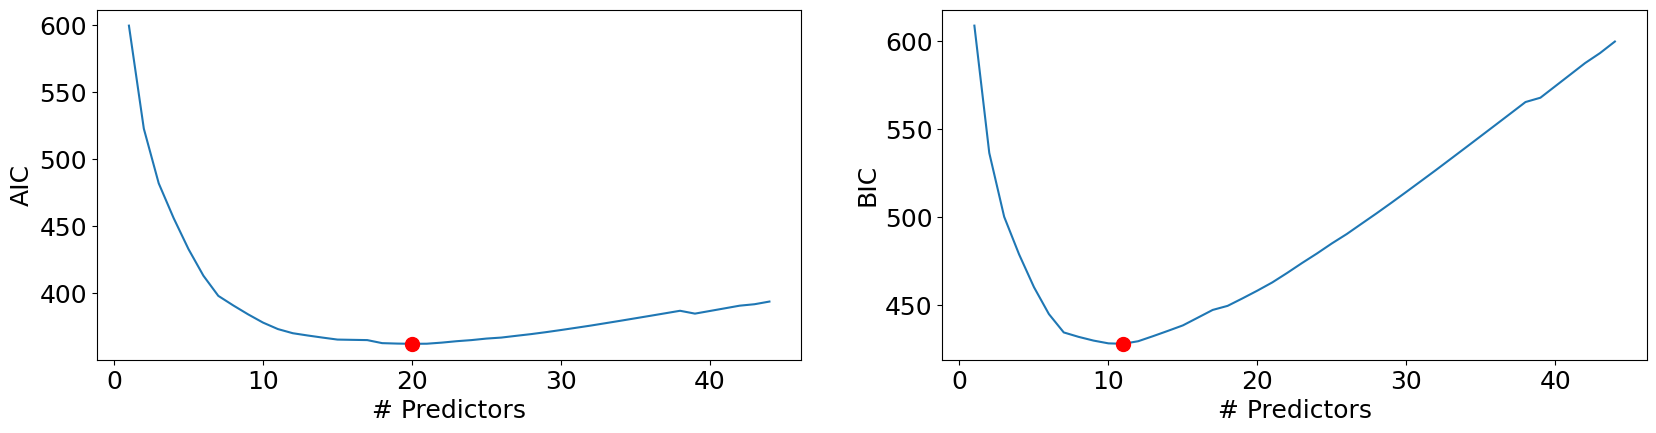

In [3542]:
best_sub_plots()

In [3550]:
best_fwd_reg_model = models_best['model'][11]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  726
Model:                          Logit   Df Residuals:                      714
Method:                           MLE   Df Model:                           11
Date:                Wed, 08 Mar 2023   Pseudo R-squ.:                  0.6533
Time:                        23:07:38   Log-Likelihood:                -174.49
converged:                       True   LL-Null:                       -503.22
Covariance Type:            nonrobust   LLR p-value:                6.976e-134
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -5.9444      1.058     -5.618      0.000      -8.018      -3.871
follicle_R                0.4267      0.057      7.494      0.000       0.315       0.538
fast_food                 1.4049      0.308      4.562      0.000       0.801       2.008
hair_growth               1.5067      0.334      4.508      0.000       0.852       2.162
cycle_ri                  0.6292      0.170      3.692      0.000       0.295       0.963
blood_group_cat_B_neg     2.5217      0.588      4.285      0.000       1.368       3.675
weight_gain               1.6218      0.316      5.136      0.000       1.003       2.241
age                      -0.0875      0.028     -3.152      0.002      -0.142      -0.033
follicle_L                0.1733      0.056      3.101      0.002       0.064       0.283
LH                        0.1123      0.058      1.926      0.054      -0.002       0.227
skin_dark                 0.9188      0.311      2.956      0.003       0.310       1.528
number_abortions         -0.6533      0.263     -2.480      0.013      -1.170      -0.137
=========================================================================================
"""

Classification accuracy = 90.3525%
False Negative = 4.5455%
False Positive = 12.1212%


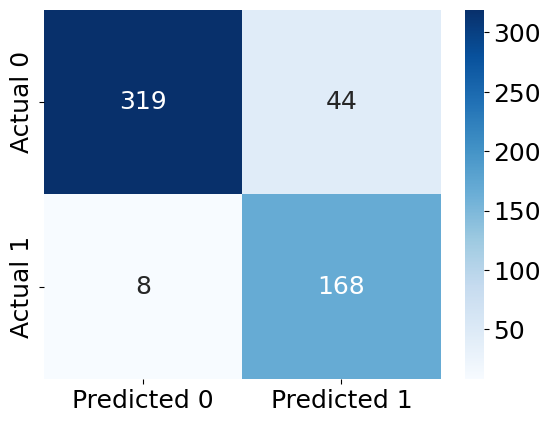

In [3551]:
confusion_matrix_test(test, test.PCOS, best_fwd_reg_model, cutoff = 0.40)

In [3549]:
# forward_subset = train.loc[:,["PCOS", "follicle_R", "hair_growth", "weight_gain", "skin_dark", "cycle_ri", "pimples", "marriage_years", "follicle_L", "blood_group_cat_B_neg", "pulse_rate", "regular_exercise", "ave_size_L"]]
# forward_subset.head()

# VIF

In [2289]:
# X = train[["follicle_R", "hair_growth", "weight_gain", "skin_dark", "cycle_ri", "pimples", "marriage_years", "follicle_L", "blood_group_cat_B_neg", "pulse_rate", "regular_exercise", "ave_size_L"]]
# X.columns[1:]
           

In [2290]:
# X = add_constant(X)
# vif_data = pd.DataFrame()
# vif_data["feature"] = X.columns

# for i in range(len(X.columns)):
#     vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

# print(vif_data)


Since the VIF for constant is very large. All predictor VIFs are very close to 1, indicating they do not have issues with collinearity. 

# EDA

### Testing if follicle_R needs transformation

In [1330]:
#Binning follicle_R
binned_fol = pd.qcut(train['follicle_R'], 5, retbins=True)
train['fol_binned'] = binned_fol[0]

In [1115]:
#Finding percentage of people having diabetes in each Age bin
fol_data = train.groupby('fol_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
fol_data

,fol_binned,PCOS_percent,nobs
0,"(-0.001, 3.0]",0.039604,101
1,"(3.0, 5.0]",0.090909,77
2,"(5.0, 7.0]",0.288136,59
3,"(7.0, 10.0]",0.564516,62
4,"(10.0, 20.0]",0.822581,62


Text(0.5, 0, 'Follicle Bins')

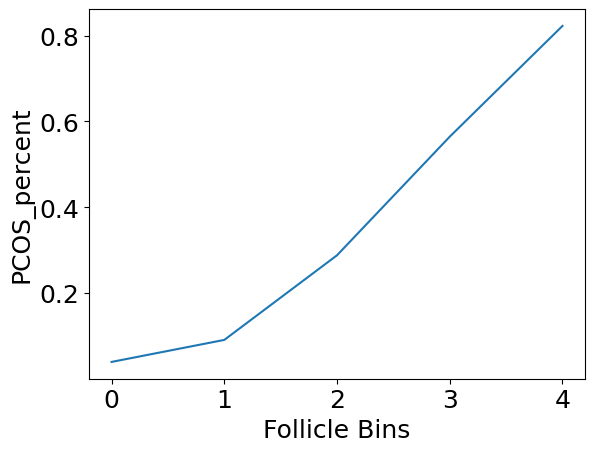

In [1116]:
sns.lineplot(x = fol_data.index, y = fol_data['PCOS_percent'])
plt.xlabel('Follicle Bins')

We observe that the probability of a person having PCOS increases with the number of follicles (collections of fluid developed in ovaries) she has. No transformation needed.

### Binning marriage_years

In [1117]:
logit_model = sm.logit('PCOS~ marriage_years', data = train).fit()

Optimization terminated successfully.
         Current function value: 0.615055
         Iterations 5


Classification accuracy = 46.6292%
False Negative = 30.6452%
False Positive = 65.5172%


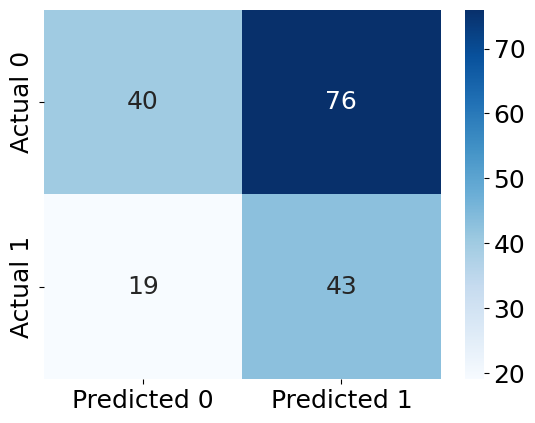

In [1118]:
confusion_matrix_test(test,test.PCOS,logit_model,0.3)

In [1119]:
#Binning marriage_years
binned_mar = pd.qcut(train['marriage_years'], 6, retbins=True)
train['mar_binned'] = binned_mar[0]

In [1120]:
#Finding percentage of people having diabetes in each Age bin
mar_data = train.groupby('mar_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
mar_data

,mar_binned,PCOS_percent,nobs
0,"(-0.001, 3.0]",0.408451,71
1,"(3.0, 5.0]",0.295082,61
2,"(5.0, 7.0]",0.383333,60
3,"(7.0, 9.0]",0.320755,53
4,"(9.0, 12.0]",0.262295,61
5,"(12.0, 30.0]",0.200000,55


Text(0.5, 0, 'marriage_years Bins')

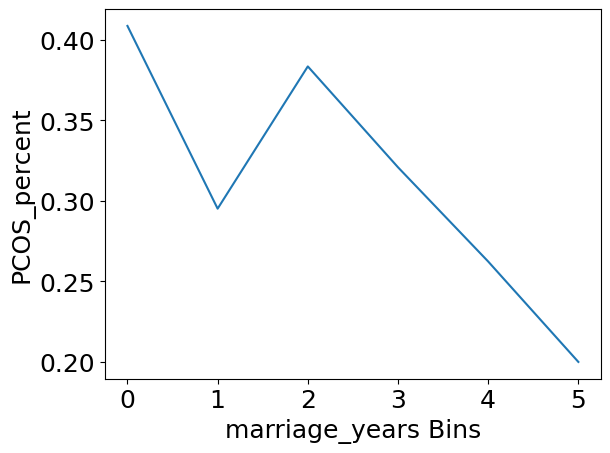

In [1121]:
sns.lineplot(x = mar_data.index, y = mar_data['PCOS_percent'])
plt.xlabel('marriage_years Bins')

Jagged relationship with PCOS percentage, consider transforming using bins

In [1122]:
#Creating a function to bin marriage_years so that it can be applied to both the test and train datasets
def var_transform(data):
    binned_mar = pd.qcut(train['marriage_years'],6,retbins=True)
    bins = binned_mar[1]
    data['mar_binned'] = pd.cut(data['marriage_years'],bins = bins)
    dum = pd.get_dummies(data.mar_binned,drop_first = True)
    dum.columns = ['marriage_years'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

In [1123]:
#Binning age using the function var_transform()
train = var_transform(train)
test = var_transform(test)

Optimization terminated successfully.
         Current function value: 0.611746
         Iterations 5


<AxesSubplot:xlabel='marriage_years', ylabel='PCOS'>

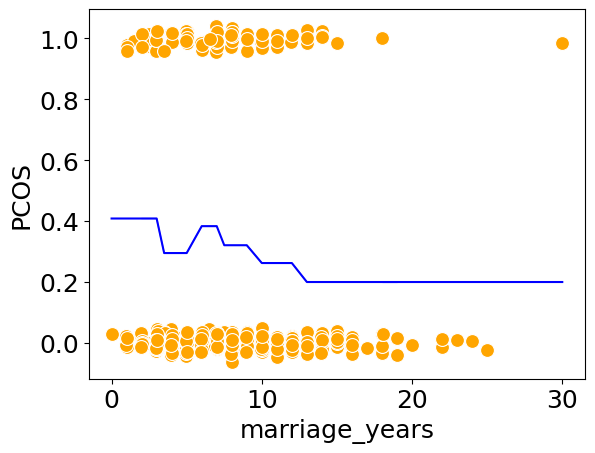

In [1124]:
#Model with binned marriage_years
sns.scatterplot(x = jitter(train.marriage_years,0), y = jitter(train.PCOS,0), data = train, color = 'orange')
logit_model2 = sm.logit(formula = 'PCOS~' + '+'.join(['marriage_years'+str(x) for x in range(1,6)]), data = train).fit()
sns.lineplot(x = 'marriage_years', y= logit_model2.predict(train), data = train, color = 'blue')


Classification accuracy = 51.1236%
False Negative = 59.6774%
False Positive = 43.1034%


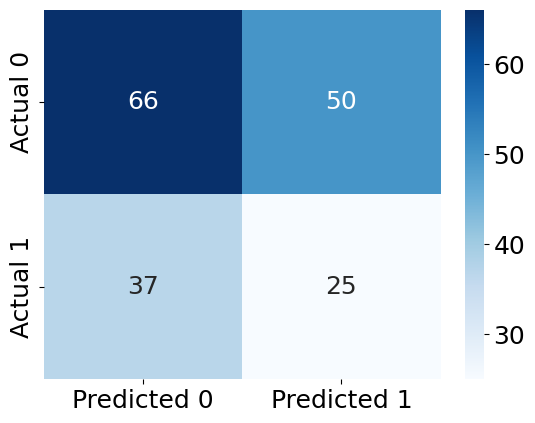

In [1125]:
confusion_matrix_test(test,test.PCOS,logit_model2,0.3)

Accuracy increased, FNR also increased. Transformation not helpful.

### Testing if endometrium needs transformation

In [1126]:
logit_model = sm.logit(formula = 'PCOS~endometrium', data = train).fit()

Optimization terminated successfully.
         Current function value: 0.614478
         Iterations 5


Classification accuracy = 44.3820%
False Negative = 35.4839%
False Positive = 66.3793%


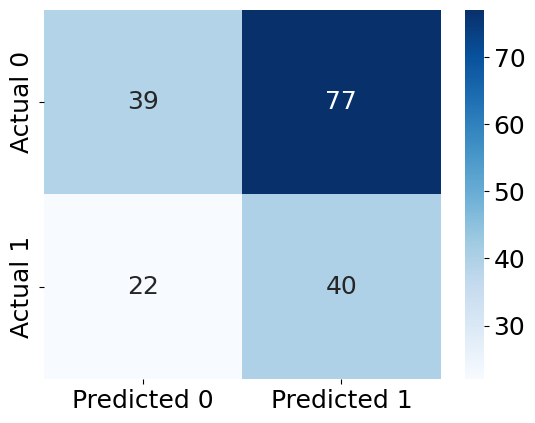

In [1127]:
confusion_matrix_test(test, test.PCOS, logit_model, cutoff = 0.3)

In [1128]:
#Binning oulse_rate
binned_endo = pd.qcut(train['endometrium'], 6, retbins=True)
train['endo_binned'] = binned_endo[0]

In [1129]:
#Finding percentage of people having diabetes in each Age bin
endo_data = train.groupby('endo_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
endo_data

,endo_binned,PCOS_percent,nobs
0,"(-0.001, 6.3]",0.213115,61
1,"(6.3, 7.5]",0.158730,63
2,"(7.5, 8.5]",0.402778,72
3,"(8.5, 9.0]",0.333333,57
4,"(9.0, 10.0]",0.452830,53
5,"(10.0, 18.0]",0.345455,55


Text(0.5, 0, 'endometrium_bin')

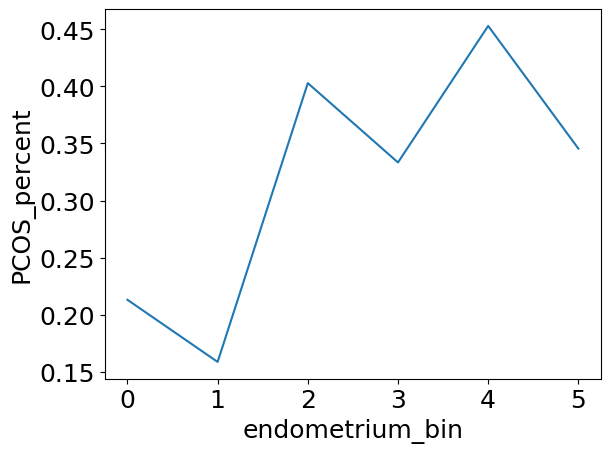

In [1130]:
sns.lineplot(x = endo_data.index, y = endo_data['PCOS_percent'])
plt.xlabel('endometrium_bin')

In [1131]:
#Creating a function to bin age so that it can be applied to both the test and train datasets
def var_transform(data):
    binned_endo = pd.qcut(train['endometrium'], 5,retbins=True)
    bins = binned_endo[1]
    data['endo_binned'] = pd.cut(data['endometrium'],bins = bins)
    dum = pd.get_dummies(data.endo_binned,drop_first = True)
    dum.columns = ['endometrium'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

In [1132]:
#Binning age using the function var_transform()
train = var_transform(train)
test = var_transform(test)

Optimization terminated successfully.
         Current function value: 0.610863
         Iterations 5


<AxesSubplot:xlabel='endometrium', ylabel='PCOS'>

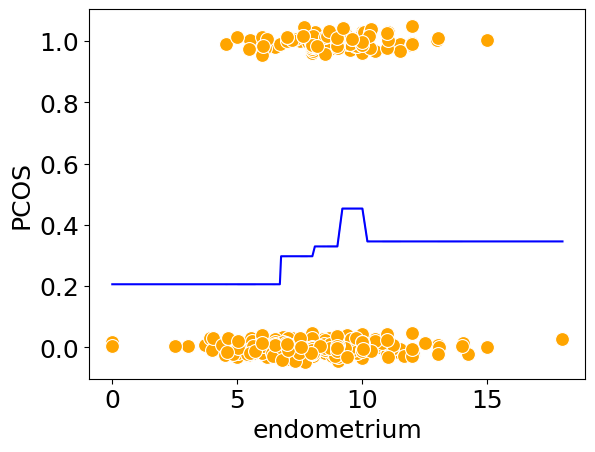

In [1133]:
#Model with binned BMI
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(train.endometrium,0), y = jitter(train.PCOS,0), data = train, color = 'orange')
logit_model = sm.logit(formula = 'PCOS~' + '+'.join(['endometrium'+str(x) for x in range(1,5)]), data = train).fit()
sns.lineplot(x = 'endometrium', y= logit_model.predict(train), data = train, color = 'blue') 



Classification accuracy = 46.6292%
False Negative = 38.7097%
False Positive = 61.2069%


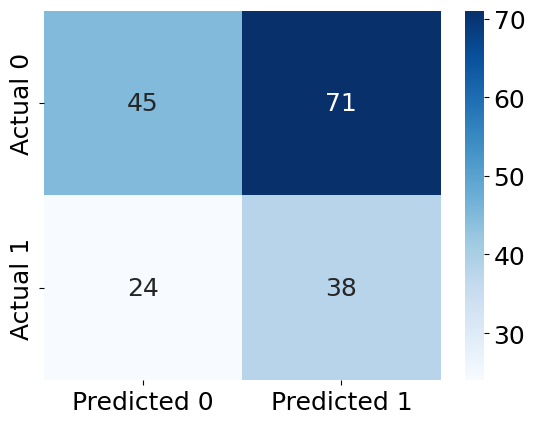

In [1134]:
confusion_matrix_test(test, test.PCOS, logit_model, cutoff = 0.3)

Accuracy increased, FNR increased. Don't include transformation of endometrium.

### Testing if height needs tranformation

In [1135]:
logit_model = sm.logit(formula = 'PCOS~height', data = train).fit()

Optimization terminated successfully.
         Current function value: 0.623586
         Iterations 5


Classification accuracy = 43.2584%
False Negative = 12.9032%
False Positive = 80.1724%


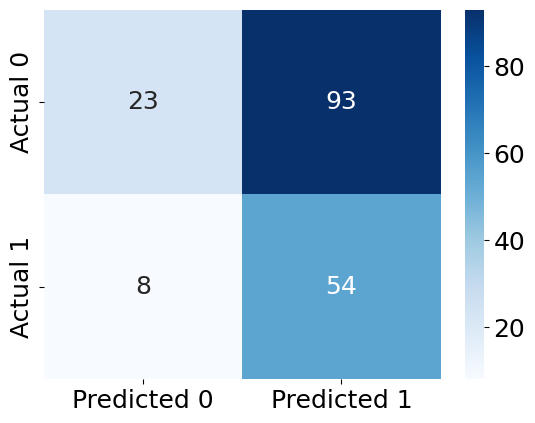

In [1136]:
confusion_matrix_test(test, test.PCOS, logit_model, cutoff = 0.31)

In [1137]:
#Binning hw_ratio
binned_height = pd.qcut(train['height'], 5, retbins=True)
train['height_binned'] = binned_height[0]

In [1138]:
#Finding percentage of people having diabetes in each Age bin
height_data = train.groupby('height_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
height_data

,height_binned,PCOS_percent,nobs
0,"(1.399, 1.52]",0.303571,112
1,"(1.52, 1.54]",0.375000,40
2,"(1.54, 1.58]",0.318681,91
3,"(1.58, 1.61]",0.307692,52
4,"(1.61, 1.8]",0.303030,66


Text(0.5, 0, 'height_bin')

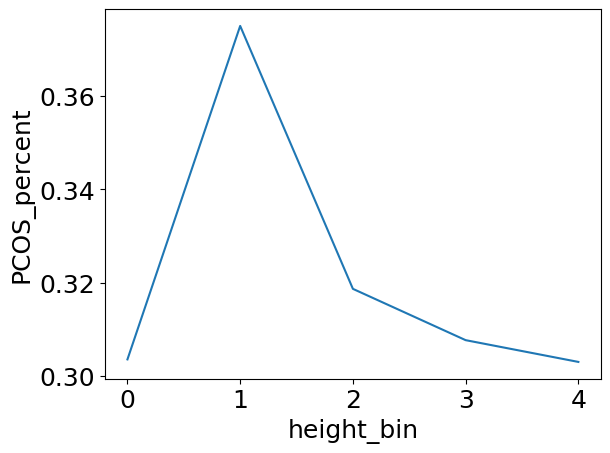

In [1139]:
sns.lineplot(x = height_data.index, y = height_data['PCOS_percent'])
plt.xlabel('height_bin')

In [1140]:
#Creating a function to bin age so that it can be applied to both the test and train datasets
def var_transform(data):
    binned_height = pd.qcut(train['height'], 5,retbins=True)
    bins = binned_height[1]
    data['height_binned'] = pd.cut(data['height'],bins = bins)
    dum = pd.get_dummies(data.height_binned,drop_first = True)
    dum.columns = ['height'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

In [1141]:
#Binning age using the function var_transform()
train = var_transform(train)
test = var_transform(test)

Optimization terminated successfully.
         Current function value: 0.622578
         Iterations 5


<AxesSubplot:xlabel='height', ylabel='PCOS'>

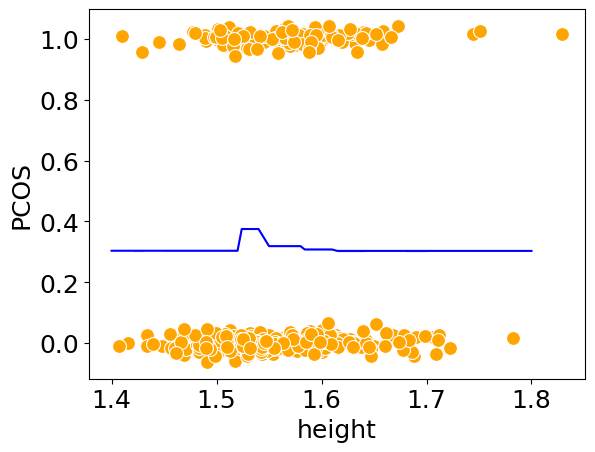

In [1142]:
#Model with binned BMI
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(train.height,0), y = jitter(train.PCOS,0), data = train, color = 'orange')
logit_model = sm.logit(formula = 'PCOS~' + '+'.join(['height'+str(x) for x in range(1,5)]), data = train).fit()
sns.lineplot(x = 'height', y= logit_model.predict(train), data = train, color = 'blue') 



Classification accuracy = 55.6180%
False Negative = 66.1290%
False Positive = 32.7586%


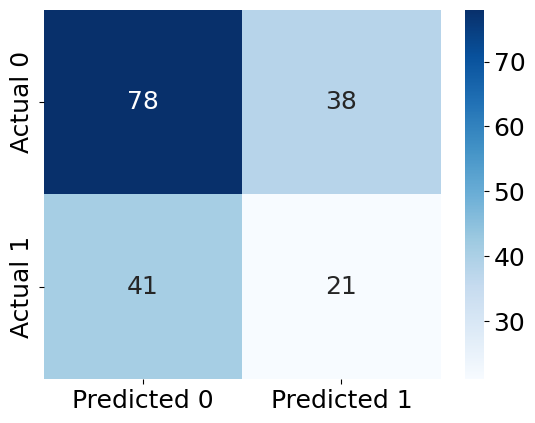

In [1143]:
confusion_matrix_test(test, test.PCOS, logit_model, cutoff = 0.31)

Accuracy increased, but so did FNR. Don't include height transformation.

# Testing Interactions

### Testing hair_loss

In [1144]:
train["hair_loss"].describe()

count    361.000000
mean       0.457064
std        0.498844
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: hair_loss, dtype: float64

In [1155]:
sub_loss = train[train.hair_loss > 0.457064]

<AxesSubplot:xlabel='PCOS', ylabel='hair_growth'>

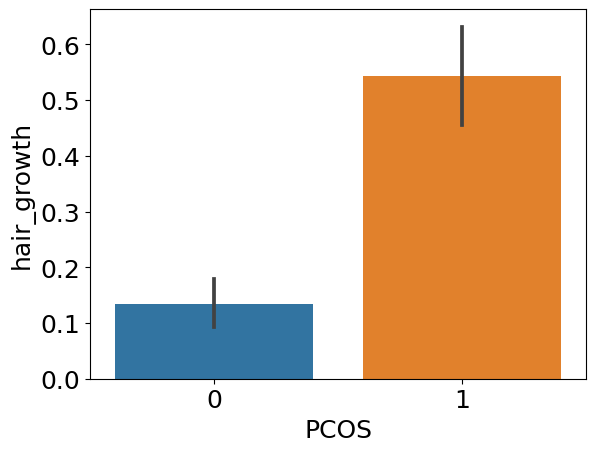

In [1156]:
sns.barplot(x = "PCOS", y = "hair_growth", data = train)

<AxesSubplot:xlabel='PCOS', ylabel='hair_growth'>

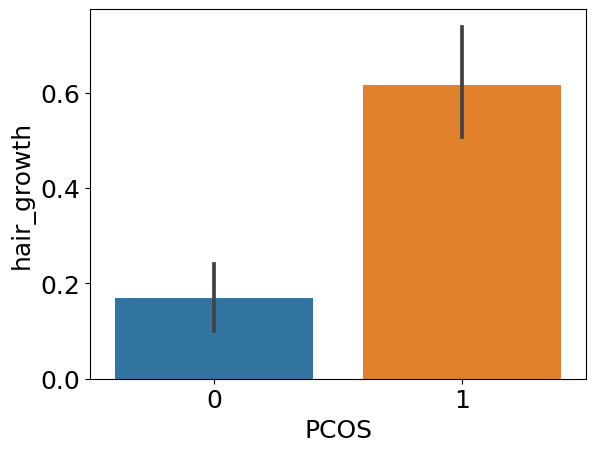

In [1157]:
sns.barplot(x = "PCOS", y = "hair_growth", data = sub_loss)

Consider adding regular_exercise*weight_gain

<AxesSubplot:xlabel='PCOS', ylabel='weight_gain'>

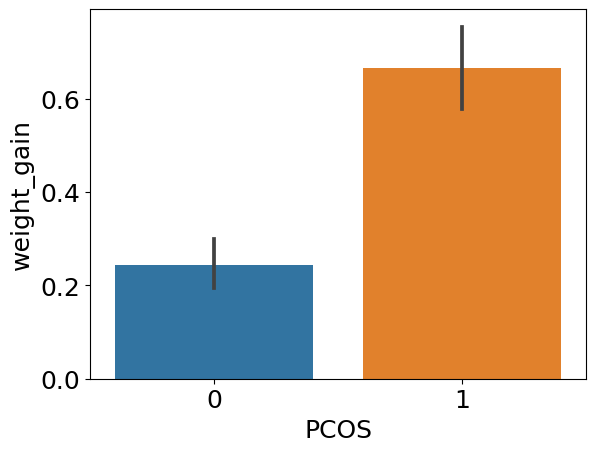

In [1239]:
sns.barplot(x = "PCOS", y = "weight_gain", data = train)

<AxesSubplot:xlabel='PCOS', ylabel='weight_gain'>

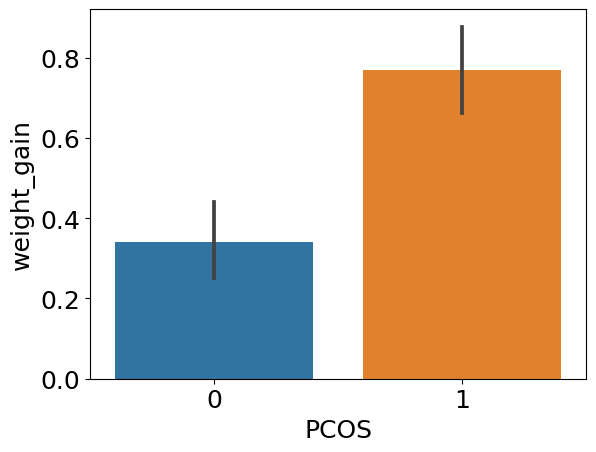

In [1240]:
sns.barplot(x = "PCOS", y = "weight_gain", data = sub_loss)

### Testing regular_exercise

In [1158]:
train["regular_exercise"].describe()

count    361.000000
mean       0.249307
std        0.433213
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: regular_exercise, dtype: float64

In [1159]:
sub_reg = train[train.regular_exercise > 0.249307]

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

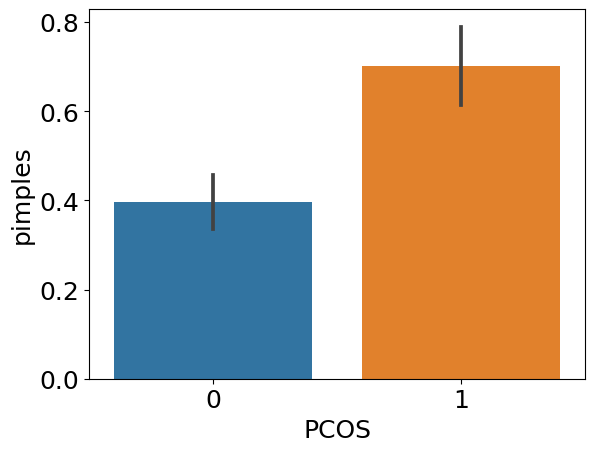

In [1160]:
sns.barplot(x = "PCOS", y = "pimples", data = train)

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

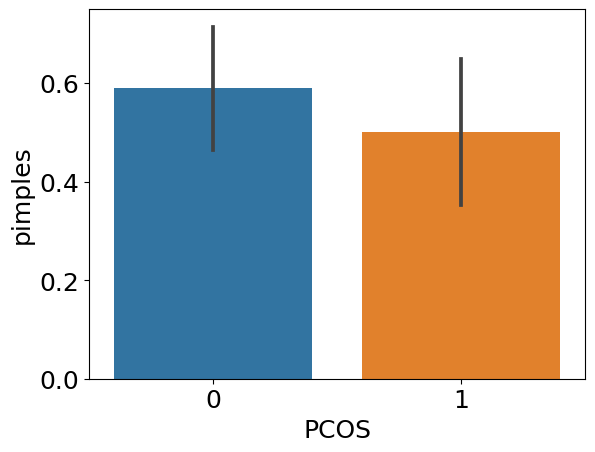

In [1161]:
sns.barplot(x = "PCOS", y = "pimples", data = sub_reg)

Significant difference between pimples and PCOS with full train and subset of those who exercise regularly a lot. Include interaction regular_exercise*pimples.

# Final Model

In [3593]:
final = sm.logit('PCOS ~ follicle_R + fast_food + hair_growth + cycle_ri + blood_group_cat_B_neg + weight_gain + age + follicle_L + LH + skin_dark + number_abortions', data = train).fit()



Optimization terminated successfully.
         Current function value: 0.240339
         Iterations 10


Classification accuracy = 90.5380%
False Negative = 4.5455%
False Positive = 11.8457%


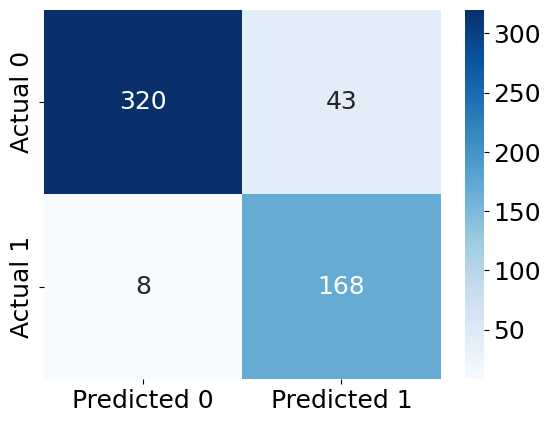

In [3599]:
confusion_matrix_test(test, test.PCOS, final, cutoff = 0.41)